# Analyse interactive du prix de l'or

Ce notebook permet d'analyser les variations du prix de l'or, de détecter les chocs importants et de visualiser les bandes de Bollinger à l'aide de Python.

## 1. Importer les bibliothèques nécessaires

Nous allons importer les bibliothèques `yfinance` pour la récupération des données financières et `matplotlib.pyplot` pour la visualisation.

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt

## 2. Télécharger les données historiques de l'or avec yfinance

Nous récupérons les prix de l'or (contrat futures, ticker `GC=F`) depuis 1980 jusqu'à 2025.

In [2]:
gold = yf.download("GC=F", start="1980-01-01", end="2025-09-01")
gold.head()

C:\Users\flore\AppData\Local\Temp\ipykernel_17952\2095207950.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold = yf.download("GC=F", start="1980-01-01", end="2025-09-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2000-08-30,273.899994,273.899994,273.899994,273.899994,0
2000-08-31,278.299988,278.299988,274.799988,274.799988,0
2000-09-01,277.000000,277.000000,277.000000,277.000000,0
2000-09-05,275.799988,275.799988,275.799988,275.799988,2
2000-09-06,274.200012,274.200012,274.200012,274.200012,0


## 3. Calculer les variations quotidiennes et en pourcentage

Ajoutons deux colonnes au DataFrame :
- `Daily Change` : variation absolue du prix de clôture d'un jour à l'autre.
- `Daily Change %` : variation en pourcentage du prix de clôture.

In [3]:
gold['Daily Change'] = gold['Close'].diff()
gold['Daily Change %'] = gold['Close'].pct_change() * 100
gold[['Close', 'Daily Change', 'Daily Change %']].head()

Price,Close,Daily Change,Daily Change %
Ticker,GC=F,,
Date,,,
2000-08-30,273.899994,NaN,NaN
2000-08-31,278.299988,4.399994,1.606424
2000-09-01,277.000000,-1.299988,-0.467117
2000-09-05,275.799988,-1.200012,-0.433217
2000-09-06,274.200012,-1.599976,-0.580122


## 4. Calculer les chocs à 2 semaines

Nous mesurons la variation du prix de clôture sur 10 jours ouvrés (environ 2 semaines) :
- `Shock_2w` : variation absolue sur 10 jours.
- `Shock_2w %` : variation en pourcentage sur 10 jours.

In [4]:
gold['Shock_2w'] = gold['Close'].shift(-10) - gold['Close']
gold['Shock_2w %'] = (gold['Close'].shift(-10) - gold['Close']) / gold['Close'] * 100
gold[['Close', 'Daily Change', 'Daily Change %', 'Shock_2w', 'Shock_2w %']].tail(10)

Price,Close,Daily Change,Daily Change %,Shock_2w,Shock_2w %
Ticker,GC=F,,,,
Date,,,,,
2025-08-18,3331.699951,-4.300049,-0.128898,NaN,NaN
2025-08-19,3313.399902,-18.300049,-0.549271,NaN,NaN
2025-08-20,3343.399902,30.000000,0.905414,NaN,NaN
2025-08-21,3336.899902,-6.500000,-0.194413,NaN,NaN
2025-08-22,3374.399902,37.500000,1.123798,NaN,NaN
2025-08-25,3373.800049,-0.599854,-0.017777,NaN,NaN
2025-08-26,3388.600098,14.800049,0.438676,NaN,NaN
2025-08-27,3404.600098,16.000000,0.472171,NaN,NaN


## 5. Calculer la volatilité mobile sur 30 jours

Nous ajoutons une colonne représentant l'écart-type glissant (rolling std) des variations quotidiennes en pourcentage sur 30 jours.

In [5]:
gold['Volatility_30d'] = gold['Daily Change %'].rolling(window=30).std()
gold[['Daily Change %', 'Volatility_30d']].tail(10)

Price,Daily Change %,Volatility_30d
Ticker,,
Date,,
2025-08-18,-0.128898,0.895814
2025-08-19,-0.549271,0.890544
2025-08-20,0.905414,0.905235
2025-08-21,-0.194413,0.905788
2025-08-22,1.123798,0.904090
2025-08-25,-0.017777,0.903646
2025-08-26,0.438676,0.897467
2025-08-27,0.472171,0.893285


## 6. Définir le seuil variable et la cible binaire pour les chocs

- `Seuil_variable` : 2 fois la volatilité mobile sur 30 jours.
- `Target_Shock` : 1 si le choc à 2 semaines (en %) dépasse ce seuil, 0 sinon.

In [6]:
gold['Seuil_variable'] = 2 * gold['Volatility_30d']
gold['Target_Shock'] = (gold['Shock_2w %'].abs() >= gold['Seuil_variable']).astype(int)
gold[['Close', 'Shock_2w %', 'Seuil_variable', 'Target_Shock']].tail(10)

Price,Close,Shock_2w %,Seuil_variable,Target_Shock
Ticker,GC=F,,,
Date,,,,
2025-08-18,3331.699951,NaN,1.791629,0
2025-08-19,3313.399902,NaN,1.781087,0
2025-08-20,3343.399902,NaN,1.810470,0
2025-08-21,3336.899902,NaN,1.811576,0
2025-08-22,3374.399902,NaN,1.808179,0
2025-08-25,3373.800049,NaN,1.807291,0
2025-08-26,3388.600098,NaN,1.794934,0
2025-08-27,3404.600098,NaN,1.786571,0


## 7. Calculer le taux de croissance moyen absolu sur 30 jours

Ajoutons la colonne `MeanGrowth_30d` qui correspond à la moyenne mobile des variations absolues en pourcentage sur 30 jours.

In [7]:
gold['MeanGrowth_30d'] = gold['Daily Change %'].abs().rolling(window=30).mean()
gold[['Daily Change %', 'MeanGrowth_30d']].tail(10)

Price,Daily Change %,MeanGrowth_30d
Ticker,,
Date,,
2025-08-18,-0.128898,0.680995
2025-08-19,-0.549271,0.674096
2025-08-20,0.905414,0.699639
2025-08-21,-0.194413,0.700282
2025-08-22,1.123798,0.698956
2025-08-25,-0.017777,0.695079
2025-08-26,0.438676,0.688120
2025-08-27,0.472171,0.681135


## 8. Définir le seuil de croissance et la cible binaire associée

- `Seuil_growth` : 2 fois le taux de croissance moyen absolu sur 30 jours.
- `Target_Shock_growth` : 1 si le choc à 2 semaines dépasse ce seuil, 0 sinon.

In [8]:
gold['Seuil_growth'] = 2 * gold['MeanGrowth_30d']
gold['Target_Shock_growth'] = (gold['Shock_2w %'].abs() >= gold['Seuil_growth']).astype(int)
gold[['Close', 'Shock_2w %', 'Seuil_growth', 'Target_Shock_growth']].tail(10)

Price,Close,Shock_2w %,Seuil_growth,Target_Shock_growth
Ticker,GC=F,,,
Date,,,,
2025-08-18,3331.699951,NaN,1.361990,0
2025-08-19,3313.399902,NaN,1.348191,0
2025-08-20,3343.399902,NaN,1.399279,0
2025-08-21,3336.899902,NaN,1.400564,0
2025-08-22,3374.399902,NaN,1.397913,0
2025-08-25,3373.800049,NaN,1.390159,0
2025-08-26,3388.600098,NaN,1.376239,0
2025-08-27,3404.600098,NaN,1.362269,0


## 9. Calculer et afficher les bandes de Bollinger

Nous ajoutons les colonnes suivantes :
- `Bollinger_MA20` : moyenne mobile sur 20 jours.
- `Bollinger_STD20` : écart-type sur 20 jours.
- `Bollinger_Upper` et `Bollinger_Lower` : bandes supérieure et inférieure.

In [9]:
gold['Bollinger_MA20'] = gold['Close'].rolling(window=20).mean()
gold['Bollinger_STD20'] = gold['Close'].rolling(window=20).std()
gold['Bollinger_Upper'] = gold['Bollinger_MA20'] + 2 * gold['Bollinger_STD20']
gold['Bollinger_Lower'] = gold['Bollinger_MA20'] - 2 * gold['Bollinger_STD20']
gold[['Close', 'Bollinger_MA20', 'Bollinger_Upper', 'Bollinger_Lower']].tail(10)

Price,Close,Bollinger_MA20,Bollinger_Upper,Bollinger_Lower
Ticker,GC=F,,,
Date,,,,
2025-08-18,3331.699951,3357.339990,3439.275527,3275.404453
2025-08-19,3313.399902,3351.049988,3425.498414,3276.601562
2025-08-20,3343.399902,3348.514978,3420.192450,3276.837506
2025-08-21,3336.899902,3346.809973,3417.854922,3275.765024
2025-08-22,3374.399902,3348.829968,3420.634643,3277.025293
2025-08-25,3373.800049,3352.064966,3422.142092,3281.987840
2025-08-26,3388.600098,3355.324976,3425.852154,3284.797797
2025-08-27,3404.600098,3360.764978,3428.696588,3292.833368


## 10. Visualiser le prix de l'or et les bandes de Bollinger

Traçons le prix de clôture de l'or, la moyenne mobile et les bandes de Bollinger.

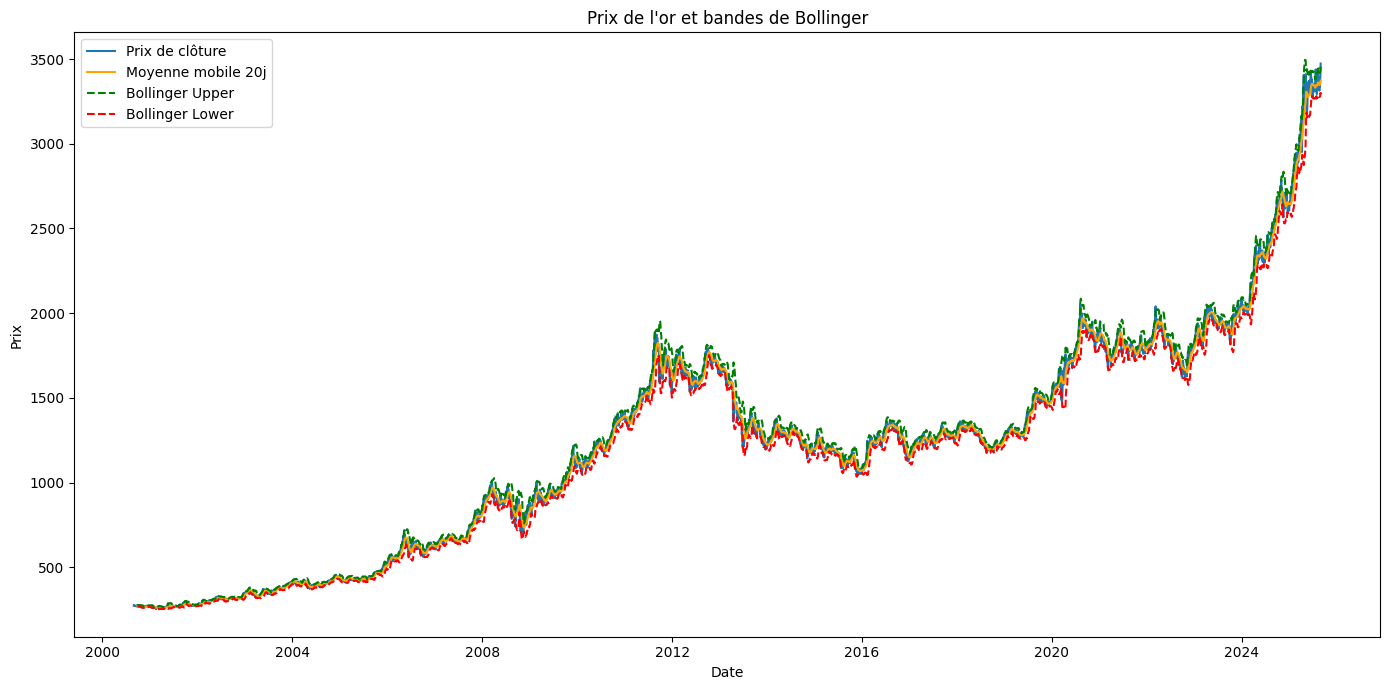

In [10]:
plt.figure(figsize=(14, 7))
plt.plot(gold['Close'], label='Prix de clôture')
plt.plot(gold['Bollinger_MA20'], label='Moyenne mobile 20j', color='orange')
plt.plot(gold['Bollinger_Upper'], label='Bollinger Upper', linestyle='--', color='green')
plt.plot(gold['Bollinger_Lower'], label='Bollinger Lower', linestyle='--', color='red')
plt.title("Prix de l'or et bandes de Bollinger")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.tight_layout()
plt.show()